# Photometry with astropy photils and AAVSO

### Using AAVSO comparison stars to perform photometry

This notebook will perform photometric analysis of an image. The magnitude of a single star will be measured by using comparison stars from AAVSO. 
The image was a 60 second exposure of YZ CNC using a Celestron C11. An Atik 383L+ camera was used with a Baader V filter.
 

First import dependencies and define a function to download the comparison stars from AAVSO's API

In [1]:
import requests, math
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
%matplotlib inline
plt.style.use('seaborn')

def get_comp_stars(ra,dec,filter_band='V',field_of_view=18.5):
    result = []
    vsp_template = 'https://www.aavso.org/apps/vsp/api/chart/?format=json&fov={}&maglimit=18.5&ra={}&dec={}'
    r = requests.get(vsp_template.format(field_of_view, ra, dec))
    print('Downloaded Comparison Star Chart ID {}'.format(r.json()['chartid']))
    for star in r.json()['photometry']:
        comparison = {}
        comparison['auid'] = star['auid']
        comparison['ra'] = star['ra']
        comparison['dec'] = star['dec']
        for band in star['bands']:
            if band['band'] == filter_band:
                comparison['vmag'] = band['mag']
                comparison['error'] = band['error']
        result.append(comparison)
    return result

### Define some constants, our target star location and the fits file to use

Here we define the position of the star that we want to measure. In this case YZ CNC. Specify the fits file location and download the comparison stars from AAVSO's API.


In [2]:
TARGET_RA = '08 10 56.65'
TARGET_DEC = '28 08 33.2'
FITS_DATA_FILE = '/home/dokeeffe/Pictures/2017-02-15-22-24-28YZCnc_Light_002.fits'

# Source detection and photometry settings
FWHM = 3.0
SOURCE_SNR = 20
APERTURE_RADIUS = 4.0

comp_stars = get_comp_stars(TARGET_RA, TARGET_DEC)


Downloaded Comparison Star Chart ID X17454ASO


### Load the image from the fits file and detect all sources using photutils

This image has also been plate solved so grab the WCS for later use to convert the x,y coordinates to RA,DEC

In [3]:
hdulist = fits.open(FITS_DATA_FILE)
data = hdulist[0].data.astype(float)
wcs = WCS(hdulist[0].header)
bkg_sigma = mad_std(data)    
daofind = DAOStarFinder(fwhm=FWHM, threshold=SOURCE_SNR*bkg_sigma)    
sources = daofind(data)
sources

/home/dokeeffe/.local/lib/python3.5/site-packages/photutils/detection/findstars.py:421: RuntimeWarning: invalid value encountered in greater
  object_labels, nobjects = ndimage.label(convolved_data > threshold,
/home/dokeeffe/.local/lib/python3.5/site-packages/photutils/detection/core.py:241: RuntimeWarning: invalid value encountered in greater
  peak_goodmask = np.logical_and(peak_goodmask, (data > threshold))


id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,1605.69146384,3.54127217988,0.391703880773,0.112279796141,0.135787868371,25.0,0.0,2111.60793464,1.13051438122,-0.133190228388
2,582.73563458,36.840287711,0.397355401581,-0.393560031717,-0.334442059596,25.0,0.0,3120.44930958,2.02267641054,-0.764816023833
3,1270.78558673,52.6389043352,0.37729461464,-0.524463784491,-0.145500111787,25.0,0.0,2215.20523711,1.38083278285,-0.35035272309
4,538.682538618,59.5724304434,0.519687665293,-0.0915634458988,-0.406248033313,25.0,0.0,1988.79713042,1.25246577216,-0.244414665363
5,134.863297019,79.1742063761,0.414073844275,0.175632028645,-0.51049736523,25.0,0.0,1625.71055612,1.04479219531,-0.0475747993109
6,399.343517141,84.7302455924,0.528567076277,-0.0969615139631,-0.481506973521,25.0,0.0,1917.49283677,1.10268549329,-0.106129152798
7,200.211995775,86.6544265298,0.404920346287,0.0467288924725,-0.25084872574,25.0,0.0,60124.3131295,40.3312241937,-4.01410351141
8,1583.76191503,106.305415424,0.462496493143,-0.0677746800685,0.0571653493118,25.0,0.0,2090.81500074,1.18224532691,-0.181769015112
9,1260.33305923,112.053272529,0.422549981256,-0.0426821006923,-0.0858038026235,25.0,0.0,5951.05192096,3.75433492405,-1.43633253351


### Now perform apperture photometry using photutils

In [4]:
positions = (sources['xcentroid'], sources['ycentroid'])    
apertures = CircularAperture(positions, r=APERTURE_RADIUS)    
phot_table = aperture_photometry(data, apertures)    
print(phot_table)   

 id      xcenter            ycenter        aperture_sum
           pix                pix                      
--- ------------------ ------------------ -------------
  1 1605.6914638419973 3.5412721798849347  55226.612585
  2  582.7356345799755 36.840287710991866  73201.152274
  3 1270.7855867312935  52.63890433515549 56597.5114776
  4   538.682538618042 59.572430443414405 45500.4718181
  5 134.86329701852907  79.17420637614863 39312.1986344
  6 399.34351714058596  84.73024559237254 44967.0857666
  7  200.2119957754602   86.6544265297642 1270298.83347
  8  1583.761915026864 106.30541542384314 49150.9653901
  9  1260.333059232291  112.0532725290789 132908.149277
 10  648.8197191799557 126.91306474657293  204772.26313
...                ...                ...           ...
 59  180.4486438682145  1085.676285949277 50334.2385028
 60 1148.7791209175134 1095.9035672153202 9717.41609564
 61 1554.5386659254718 1131.5844608631253 48672.7061143
 62   861.089134046802 1138.6423080839236 443610

### Now we need to start using this data with the comparison star's data.

The phot_table above contains the fluxes for all detected sources in the image. However we are only interested in the handful of comparison stars and our target star.

First get the x-y pixel coordinates of our target star from the ra-dec position using the image's wcs.

In [5]:
target = SkyCoord('08 10 56.65','28 08 33.2', unit=(u.hourangle, u.deg))
target_xy = SkyCoord.to_pixel(target, wcs=wcs, origin=1)
target_xy

(array(890.1977733219449), array(598.0755941375137))

### Join our photometric measurements table with the list of comparison stars

Now for each comparison star find the corresponding source in the image by finding the closest detetected source.
Closest to +- 3 pixels. We will also add our target star into the results. It will be the only one in the results table which is missing the magnitude **vmag**. We will determine this later

In [6]:
comp_stars.append({'auid': 'target', 'ra': TARGET_RA, 'dec': TARGET_DEC})

for comp_star in comp_stars:
    comp_coord = SkyCoord(comp_star['ra'],comp_star['dec'], unit=(u.hourangle, u.deg))
    xy = SkyCoord.to_pixel(comp_coord, wcs=wcs, origin=1)
    x = xy[0].item(0)
    y = xy[1].item(0)
    for phot_measurement in phot_table:
        if(phot_measurement['xcenter'].value-4 < x < phot_measurement['xcenter'].value+4) and phot_measurement['ycenter'].value-4 < y < phot_measurement['ycenter'].value+4:
            comp_star['x'] = x
            comp_star['y'] = y
            comp_star['measured_flux'] = phot_measurement['aperture_sum']
            if not math.isnan(phot_measurement['aperture_sum']):
                comp_star['measured_instrumental_mag'] = -2.5 * math.log10(phot_measurement['aperture_sum'])
    
results = pd.DataFrame(comp_stars)
results

,auid,dec,error,measured_flux,measured_instrumental_mag,ra,vmag,x,y
0,000-BBP-196,28:00:37.1,0.008,762791.485278,-14.706015,08:10:44.03,10.861,1033.463728,970.464843
1,000-BBP-235,28:14:32.8,0.019,83702.736747,-12.306849,08:11:32.31,13.354,507.986765,324.264278
2,000-BBP-199,28:12:54.0,0.008,62279.729638,-11.985867,08:10:52.82,13.688,924.194538,390.326094
3,000-BBP-225,28:12:48.0,0.011,45289.031975,-11.639983,08:11:19.08,14.093,649.161686,403.310676
4,000-BKT-684,28:09:50.3,0.014,38720.695913,-11.469858,08:10:22.27,14.290,1248.352628,525.851077
5,000-BKT-685,28:13:02.4,0.028,NaN,NaN,08:11:25.90,14.470,NaN,NaN
6,000-BBP-218,28:07:34.6,0.000,NaN,NaN,08:11:11.57,15.004,NaN,NaN
7,000-BKT-686,28:11:04.3,0.006,NaN,NaN,08:10:25.08,15.366,NaN,NaN
8,000-BKT-687,28:12:56.1,0.009,NaN,NaN,08:11:14.52,15.726,NaN,NaN
9,000-BKT-688,28:08:57.8,0.013,NaN,NaN,08:11:16.46,16.164,NaN,NaN


### Plot the image data, the comparison stars and the target star

Just to see which actual stars correspond to the detected sources. Plot these with the image data

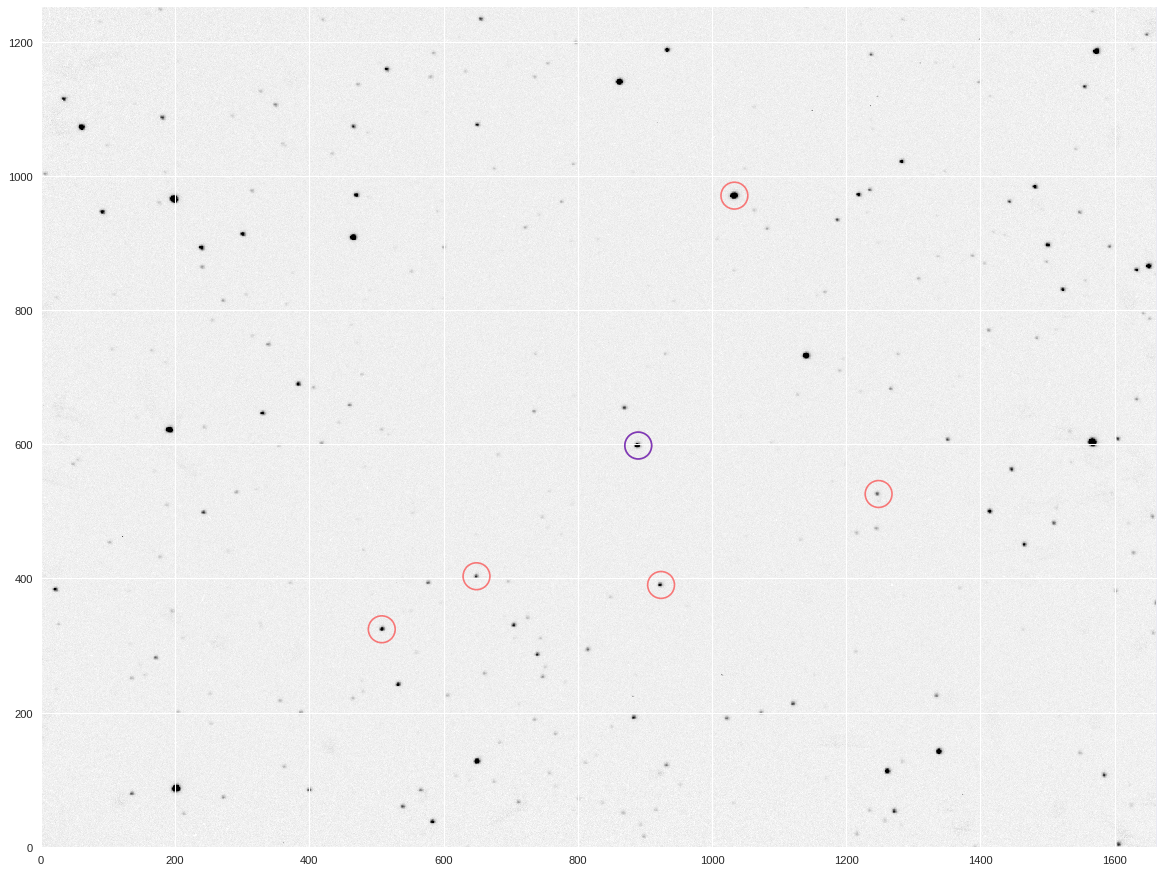

In [7]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
positions = (results['x'], results['y'])    
position_apps = CircularAperture(positions, r=20.)    
target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
position_apps.plot(color='red', lw=1.5, alpha=0.5)
target_app.plot(color='blue', lw=1.5, alpha=0.5)

### Plot the AAVSO magnitude against our measured instrumental magnitude

This should be linear. We will also fit the data using a linear fit function so that the magnitude of the target can be determined.

/home/dokeeffe/.local/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


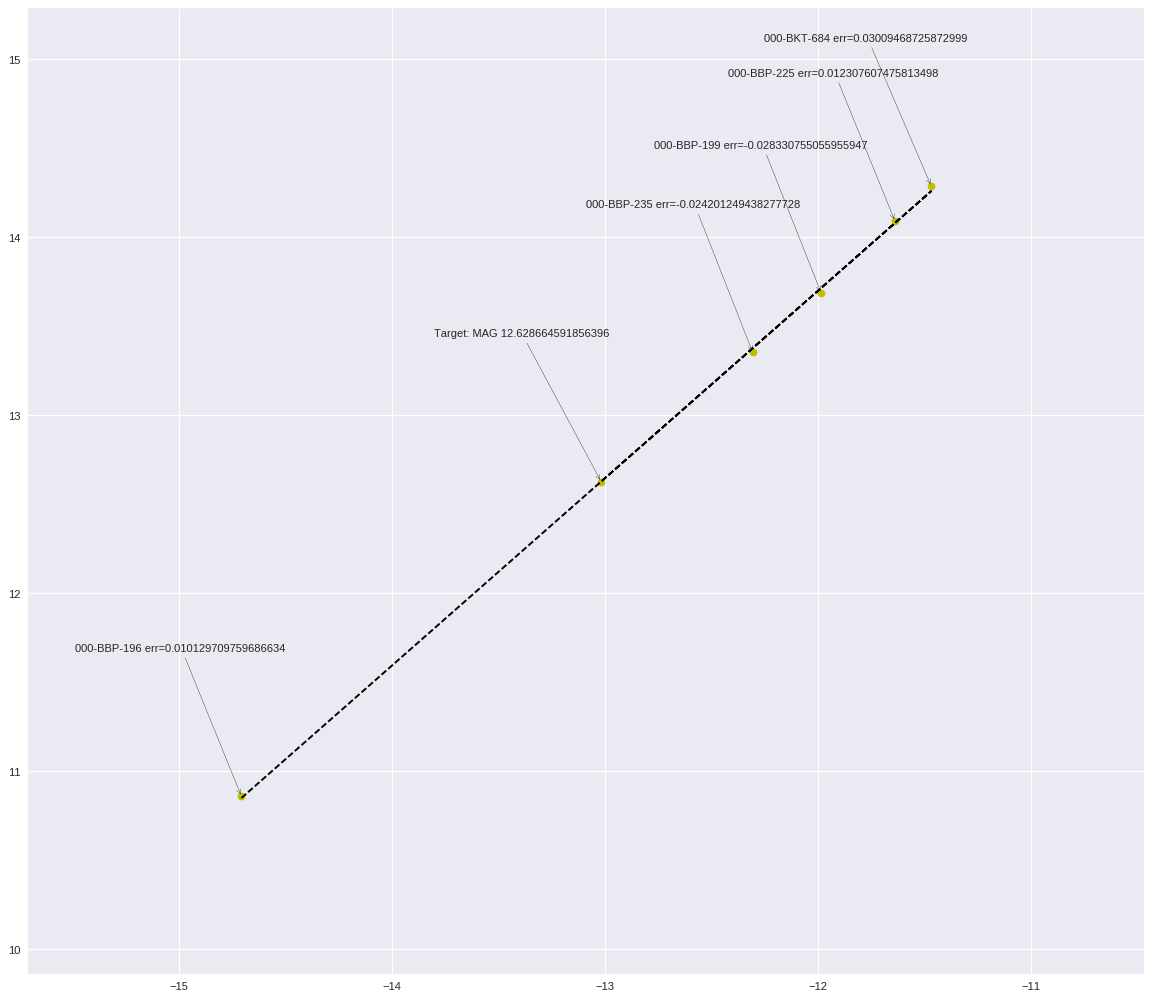

In [8]:
to_plot = results.query('vmag > -9999 and measured_flux > 0')
x = to_plot['measured_instrumental_mag'].values
y = to_plot['vmag'].values
fit = np.polyfit(x,y,1)
fit_fn = np.poly1d(fit) 
# fit_fn is now a function which takes in x and returns an estimate for y
to_plot['calculated_magnitude'] = to_plot[['measured_instrumental_mag']].apply(fit_fn)
        
    
target_instrumental_magnitude = results[results.auid=='target']['measured_instrumental_mag'].values[0]
target_converted_magnitude = fit_fn(target_instrumental_magnitude)
x = np.append(x,target_instrumental_magnitude)
y = np.append(y,target_converted_magnitude)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(x,y, 'yo', x, fit_fn(x), '--k')
plt.plot(target_xy)
plt.xlim(np.min(x)-1, np.max(x)+1)
plt.ylim(np.min(y)-1, np.max(y)+1)
plt.annotate('Target: MAG {}'.format(target_converted_magnitude),
            xy=(target_instrumental_magnitude, target_converted_magnitude), xycoords='data',
            xytext=(-150, 130), textcoords='offset points',
            arrowprops=dict(arrowstyle="->"))
for to_annotate in to_plot.iterrows():
    plt.annotate('{} err={} '.format(to_annotate[1]['auid'],to_annotate[1]['vmag']-to_annotate[1]['calculated_magnitude']),
        xy=(to_annotate[1]['measured_instrumental_mag'], to_annotate[1]['vmag']), xycoords='data',
        xytext=(-150, 130), textcoords='offset points',
        arrowprops=dict(arrowstyle="->"))


In [9]:
to_plot

,auid,dec,error,measured_flux,measured_instrumental_mag,ra,vmag,x,y,calculated_magnitude
0,000-BBP-196,28:00:37.1,0.008,762791.485278,-14.706015,08:10:44.03,10.861,1033.463728,970.464843,10.850870
1,000-BBP-235,28:14:32.8,0.019,83702.736747,-12.306849,08:11:32.31,13.354,507.986765,324.264278,13.378201
2,000-BBP-199,28:12:54.0,0.008,62279.729638,-11.985867,08:10:52.82,13.688,924.194538,390.326094,13.716331
3,000-BBP-225,28:12:48.0,0.011,45289.031975,-11.639983,08:11:19.08,14.093,649.161686,403.310676,14.080692
4,000-BKT-684,28:09:50.3,0.014,38720.695913,-11.469858,08:10:22.27,14.290,1248.352628,525.851077,14.259905


### Determine the magnitude of the target

The target magnitude is not plotted above, however we can use the plot fit to determine the real magnitude based on the instrumental magnitude.

In [10]:
target_instrumental_magnitude = results[results.auid=='target']['measured_instrumental_mag'].values[0]
converted_magnitude = fit_fn(target_instrumental_magnitude)
converted_magnitude

12.628664591856396

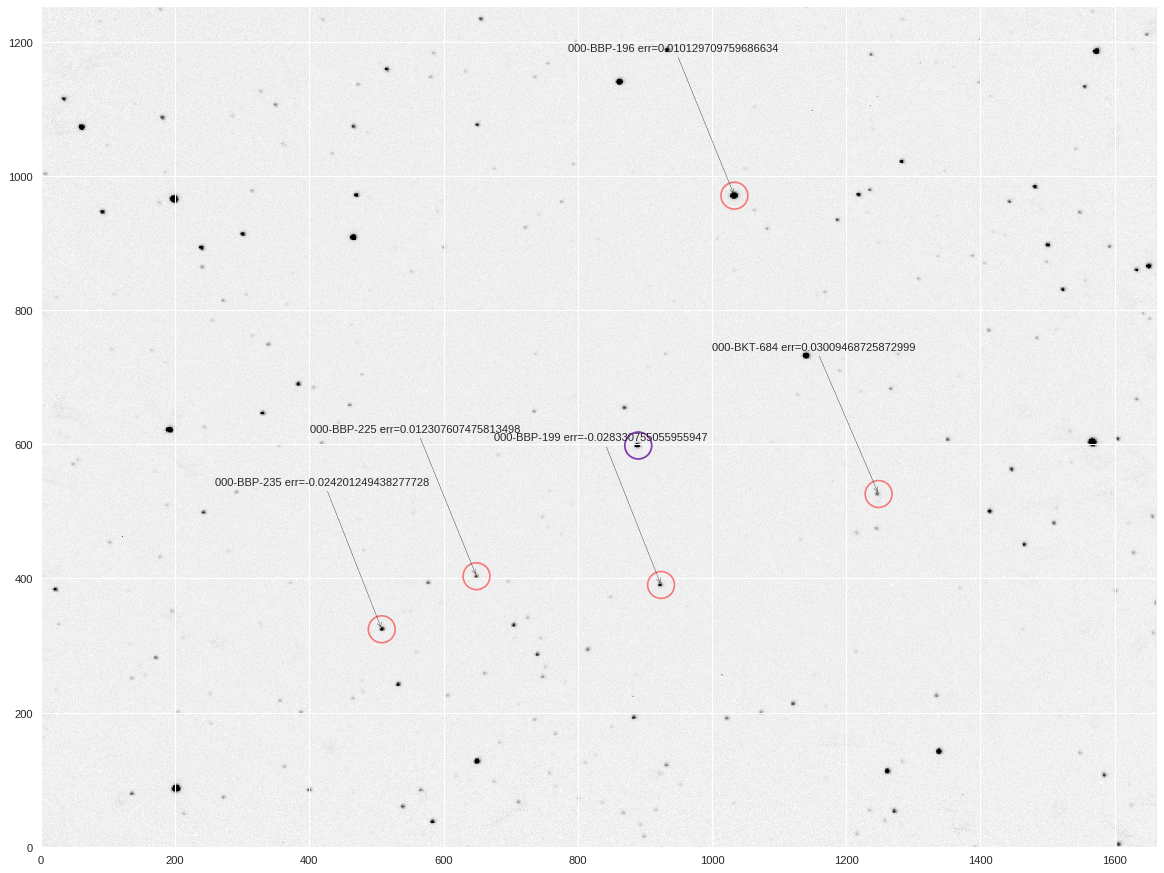

In [11]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
positions = (results['x'], results['y'])    
position_apps = CircularAperture(positions, r=20.)    
target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
position_apps.plot(color='red', lw=1.5, alpha=0.5)
target_app.plot(color='blue', lw=1.5, alpha=0.5)
for to_annotate in to_plot.iterrows():
    plt.annotate('{} err={} '.format(to_annotate[1]['auid'],to_annotate[1]['vmag']-to_annotate[1]['calculated_magnitude']),
        xy=(to_annotate[1]['x'], to_annotate[1]['y']), xycoords='data',
        xytext=(-150, 130), textcoords='offset points',
        arrowprops=dict(arrowstyle="->"))


In [12]:
z, residuals, rank, singular_values, rcond = np.polyfit(x, y, 1, full=True)
residuals

array([ 0.00254811])